# Foundations of Agentic AI Systems - CA2

## Imports and Load Environment

In [1]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain.tools import tool
from langsmith import Client, wrappers
from pydantic import BaseModel, Field
from typing_extensions import Annotated
from langgraph.managed.is_last_step import RemainingSteps
from langchain_google_genai import ChatGoogleGenerativeAI
import os, re , ast, tempfile, subprocess, openai
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)
from time import sleep
from langgraph.graph.message import add_messages 

import pandas as pd


load_dotenv()

/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


True

## Load and prepare the CSV for later use in the dataset

In [74]:
df = pd.read_csv('mbpp_san_train.csv', usecols=['task_id','prompt','code','test_list'])
df = df.iloc[0:20]
df.head(20)

,task_id,prompt,code,test_list
0,602,Write a python function to find the first repe...,"def first_repeated_char(str1):\n for index,c ...","['assert first_repeated_char(""abcabc"") == ""a""'..."
1,603,Write a function to get all lucid numbers smal...,def get_ludic(n):\n\tludics = []\n\tfor i in r...,"['assert get_ludic(10) == [1, 2, 3, 5, 7]'\n '..."
2,604,Write a function to reverse words seperated by...,def reverse_words(s):\n return ' '.join...,"['assert reverse_words(""python program"")==(""pr..."
3,605,Write a function to check if the given integer...,def prime_num(num):\n if num >=1:\n for i i...,['assert prime_num(13)==True' 'assert prime_nu...
4,606,Write a function to convert degrees to radians.,import math\ndef radian_degree(degree):\n radi...,['assert radian_degree(90)==1.5707963267948966...
5,607,Write a function to search a string for a rege...,"import re\n\ndef find_literals(text, pattern):...","[""assert find_literals('The quick brown fox ju..."
6,608,Write a python function to find nth bell number.,def bell_Number(n): \n bell = [[0 for i in ...,['assert bell_Number(2) == 2' 'assert bell_Num...
7,610,Write a python function which takes a list and...,"def remove_kth_element(list1, L):\n return ...","['assert remove_kth_element([1,1,2,3,4,4,5,1],..."
8,611,Write a function which given a matrix represen...,"def max_of_nth(test_list, N):\n res = max([su...","['assert max_of_nth([[5, 6, 7], [1, 3, 5], [8,..."
9,612,Write a python function which takes a list of ...,def merge(lst): \n return [list(ele) for e...,"[""assert merge([['x', 'y'], ['a', 'b'], ['m', ..."


In [75]:
def extract_function_names(code: str):
    """
    Return a list of function names found in `code`.
    Checks for both top-level functions and methods within classes.
    Falls back to a regex search if AST parsing fails.
    """
    if not isinstance(code, str) or not code.strip():
        return []
    names = []
    try:
        tree = ast.parse(code)
        for node in tree.body:
            if isinstance(node, (ast.FunctionDef, ast.AsyncFunctionDef)):
                names.append(node.name)
            elif isinstance(node, ast.ClassDef):
                for item in node.body:
                    if isinstance(item, (ast.FunctionDef, ast.AsyncFunctionDef)):
                        names.append(f"{node.name}.{item.name}")
        return names
    except SyntaxError:
        # fallback: find `def name(` or `async def name(` (simple)
        matches = re.findall(r'^\s*(?:async\s+)?def\s+([A-Za-z_][A-Za-z_0-9]*)\s*\(', code, flags=re.MULTILINE)
        return matches

# apply to dataframe  
df['function_names'] = df['code'].fillna('').apply(extract_function_names)
# Save first function name or None
df['function_name'] = df['function_names'].apply(lambda l: l[0] if l else None)

print(df[['task_id','function_name']].head(20))

    task_id        function_name
0       602  first_repeated_char
1       603            get_ludic
2       604        reverse_words
3       605            prime_num
4       606        radian_degree
5       607        find_literals
6       608          bell_Number
7       610   remove_kth_element
8       611           max_of_nth
9       612                merge
10      614      cummulative_sum
11      615        average_tuple
12      616         tuple_modulo
13      617            min_Jumps
14      618             div_list
15      619             move_num
16      620       largest_subset
17      622           get_median
18      623             nth_nums
19      624             is_upper


In [76]:
#drop the function_names column as not needed
df.drop(columns=['function_names'], inplace=True)
df.head(20)

,task_id,prompt,code,test_list,function_name
0,602,Write a python function to find the first repe...,"def first_repeated_char(str1):\n for index,c ...","['assert first_repeated_char(""abcabc"") == ""a""'...",first_repeated_char
1,603,Write a function to get all lucid numbers smal...,def get_ludic(n):\n\tludics = []\n\tfor i in r...,"['assert get_ludic(10) == [1, 2, 3, 5, 7]'\n '...",get_ludic
2,604,Write a function to reverse words seperated by...,def reverse_words(s):\n return ' '.join...,"['assert reverse_words(""python program"")==(""pr...",reverse_words
3,605,Write a function to check if the given integer...,def prime_num(num):\n if num >=1:\n for i i...,['assert prime_num(13)==True' 'assert prime_nu...,prime_num
4,606,Write a function to convert degrees to radians.,import math\ndef radian_degree(degree):\n radi...,['assert radian_degree(90)==1.5707963267948966...,radian_degree
5,607,Write a function to search a string for a rege...,"import re\n\ndef find_literals(text, pattern):...","[""assert find_literals('The quick brown fox ju...",find_literals
6,608,Write a python function to find nth bell number.,def bell_Number(n): \n bell = [[0 for i in ...,['assert bell_Number(2) == 2' 'assert bell_Num...,bell_Number
7,610,Write a python function which takes a list and...,"def remove_kth_element(list1, L):\n return ...","['assert remove_kth_element([1,1,2,3,4,4,5,1],...",remove_kth_element
8,611,Write a function which given a matrix represen...,"def max_of_nth(test_list, N):\n res = max([su...","['assert max_of_nth([[5, 6, 7], [1, 3, 5], [8,...",max_of_nth
9,612,Write a python function which takes a list of ...,def merge(lst): \n return [list(ele) for e...,"[""assert merge([['x', 'y'], ['a', 'b'], ['m', ...",merge


In [77]:
def extract_assert_statements(input_string):
    """
    Extract assert statements from a string representation of a list
    """
    if pd.isna(input_string) or input_string == '':
        return []
    
    try:
        # First pass normalization
        normalized = re.sub(r"'\s*\n\s*'", "', '", input_string)
        
        # Second pass: fix missing commas between adjacent quotes
        # This handles cases like "'assert1' 'assert2'" -> "'assert1', 'assert2'"
        normalized = re.sub(r"'(\s*)'", r"',\1'", normalized)
        
        parsed = ast.parse(normalized, mode='eval')
        return [element.value for element in parsed.body.elts 
                if isinstance(element, ast.Constant) and isinstance(element.value, str)]
    except Exception as e:
        print(f"AST parsing failed: {e}")
        return extract_assert_statements_fallback(input_string)

def extract_assert_statements_fallback(input_string):
    """
    Robust fallback method that handles various formatting issues
    """
    # Remove outer brackets and quotes
    cleaned = input_string.strip().strip('[]')
    
    # Method 1: Split by the pattern that separates assert statements
    # This handles both comma-separated and space-separated cases
    statements = re.split(r"',\s*'|\'\s+\'", cleaned)
    
    # Clean each statement
    cleaned_statements = []
    for stmt in statements:
        stmt = stmt.strip().strip("'")
        if stmt and stmt.startswith('assert'):
            cleaned_statements.append(stmt)
    
    # Method 2: If the above doesn't capture enough, use direct pattern matching
    if len(cleaned_statements) < 2:  # If we didn't find enough statements
        statements = re.findall(r"assert [^']+", cleaned)
        cleaned_statements = [stmt.strip() for stmt in statements if stmt.strip()]
    
    return cleaned_statements

# Apply the extraction function
df['test_list_extracted'] = df['test_list'].apply(extract_assert_statements)
df[['function_name','test_list_extracted']].head(20)

,function_name,test_list_extracted
0,first_repeated_char,"[assert first_repeated_char(""abcabc"") == ""a"", ..."
1,get_ludic,"[assert get_ludic(10) == [1, 2, 3, 5, 7], asse..."
2,reverse_words,"[assert reverse_words(""python program"")==(""pro..."
3,prime_num,"[assert prime_num(13)==True, assert prime_num(..."
4,radian_degree,"[assert radian_degree(90)==1.5707963267948966,..."
5,find_literals,[assert find_literals('The quick brown fox jum...
6,bell_Number,"[assert bell_Number(2) == 2, assert bell_Numbe..."
7,remove_kth_element,"[assert remove_kth_element([1,1,2,3,4,4,5,1],3..."
8,max_of_nth,"[assert max_of_nth([[5, 6, 7], [1, 3, 5], [8, ..."
9,merge,"[assert merge([['x', 'y'], ['a', 'b'], ['m', '..."


##  Pydantic Classes for Structured Outputs and to be used in the State

In [6]:
class TestCode(BaseModel):
    test_code: str = Field(description="The python code for the test cases to validate given python code.")
    description: str = Field(description="A brief description of what the test cases are validating.")
    how_to_use: str = Field(description="Instructions on how to use the test cases.")

class SolutionCode(BaseModel):
    solution_code: str = Field(description="The solution code for the given python task.")
    description: str = Field(description="A brief description of the solution code.")
    how_to_use: str = Field(description="Instructions on how to use the solution code.")

## Tool for executing code

In [7]:
@tool
def execute_code_sub(code: str = Field(description="Code to be executed.")) -> str:
    """Executes the given Python code and returns the output or error message."""
    try:
        # Create a temporary file
        with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as f:
            f.write(code)
            temp_file = f.name
        
        # Execute the file
        result = subprocess.run(
            ['python', temp_file],
            capture_output=True,
            text=True,
            timeout=30
        )
        
        # Clean up
        os.unlink(temp_file)
        
        if result.returncode == 0:
            return "TEST_PASSED"
        else:
            return f"Error: {result.stderr.strip()}"
            
    except subprocess.TimeoutExpired:
        return "Error: Execution timed out"
    except Exception as e:
        return f"Error: {e}"

## Definitions for Model, State, Nodes and Graph

E0000 00:00:1764160769.366889    6767 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


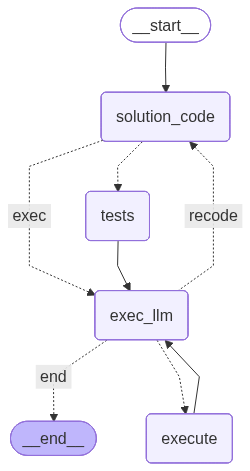

In [ ]:
# MODEL
llm = ChatGoogleGenerativeAI(
    model=os.getenv("GOOGLE_API_MODEL"),
    temperature=0)

#Model to generate the solution code
solution_code_model = llm.with_structured_output(SolutionCode)
#Model to generate the test code
test_code_model = llm.with_structured_output(TestCode)


# STATE
class ExecutionState(BaseModel):
    tests_generated: bool = Field(default=False, description="Flag indicating if tests have been generated.")
    test_code: TestCode = None
    test_run: bool = Field(default=False, description="Flag indicating if tests have been run.")
    test_passed: bool = Field(default=False, description="Flag indicating if tests have passed.")
    solution_code: SolutionCode = None
    messages: Annotated[list[AnyMessage], add_messages]
    remaining_steps: RemainingSteps = RemainingSteps()
    


##### NODES #######

#node for generating the test code from the generated solution code
def generate_code_tests(state: ExecutionState) -> dict:
    system_message = """
    You are an expert Python programmer. Write tests that can be executed directly without needing function definitions. 
    Use print statements to show test results.
    """
    instruction_message = """
    Write python test code for the following python code. The tests should print "PASSED" if all tests pass or show the specific error if any fail.
    
    Code to test: {solution_code}
    """
    
    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=instruction_message.format(solution_code=state.solution_code.solution_code))
    ]
    
    response = test_code_model.invoke(messages)
    return {
        "test_code": response, 
        "tests_generated": True
    }

#node for generating the solution code from the task description
def generate_solution_code(state: ExecutionState) -> dict:
    if not state.solution_code:
        response = solution_code_model.invoke(state.messages)
        return {"solution_code": response}
    else:
        # Only gets here if tests have failed and we need to recode
        system_message = """
        You are an expert Python programmer. You will be provided with a task. Write a solution to the task using python. Maintain proper code structure and include comments where necessary.
        """
        instruction_message = """
        The solution code provided earlier did not pass the tests.Review and fix the solution code to ensure it passes all tests.
        
        Solution Code: {solution_code}  
        
        Execution Results: {results}
        
        Respond with the corrected solution code only.
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(
                solution_code=state.solution_code.solution_code,
                results=state.messages[-1].content,
            ))
        ]
        result = solution_code_model.invoke(messages)

        return {"test_run": False, "solution_code": result}



def exec_llm(state: ExecutionState) -> dict:
    execution_llm = llm.bind_tools([execute_code_sub])
    

    system_message = """
    You are an expert Python code tester. Execute the test code and analyze the results.
    If tests pass, respond with "TEST_PASSED". If tests fail, respond with "TEST_FAILED" and the error details.
    """
    
    # Check if we have tool results to process
    tool_results = []

    if isinstance(state.messages[-1], ToolMessage) and state.messages[-1].content:
        tool_results.append(state.messages[-1].content)
    
    if tool_results:
        # We have execution results to analyze
        instruction_message = """
        Analyze these test execution results and determine if the tests passed or failed:
        
        Test Code: {test_code}
        
        Execution Results: {results}
        
        Respond with "TEST_PASSED" if all tests passed, or "TEST_FAILED" with error details if any tests failed.
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(
                test_code=state.test_code.test_code,
                results="\n".join(tool_results)
            ))
        ]
        result = execution_llm.invoke(messages)

        return {"messages": [result], "test_run": True, "test_passed": "TEST_PASSED" in result.content}
    else:
        # First call - need to execute the tests
        instruction_message = """
        Execute this test code and return the results: {test_code}
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(test_code=state.test_code.test_code))
        ]
    
        result = execution_llm.invoke(messages)

        return {"messages": [result]}


def pass_fail(state: ExecutionState) -> str:
    # Look for PASSED/FAILED in recent messages
    if (state.test_run and state.test_passed) or state.remaining_steps  <= 4:
        return "end"
    elif not state.test_run:
        return "execute"
    else:
        return "recode"


def skip_if_tests_generated(state: ExecutionState) -> str:
    return "tests" if not state.tests_generated else "exec"


# GRAPH

graph = StateGraph(ExecutionState)
graph.add_node("solution_code", generate_solution_code)
graph.add_node("tests", generate_code_tests)
graph.add_node("exec_llm", exec_llm)
graph.add_node("execute", ToolNode(tools=[execute_code_sub]))

graph.add_edge(START, "solution_code")
graph.add_edge("tests", "exec_llm")
graph.add_edge("execute", "exec_llm")

graph.add_conditional_edges("exec_llm", pass_fail, path_map={ "end": END, "recode": "solution_code", "execute": "execute" })
graph.add_conditional_edges("solution_code", skip_if_tests_generated, path_map={ "tests": "tests", "exec": "exec_llm" })



mbpp_graph = graph.compile()

mbpp_graph



## Create Dataset

In [78]:
# create LangSmith client
ls_client = Client()
dataset_name = "CA2 Dataset 1"
dataset = ls_client.create_dataset(dataset_name)

In [47]:
#Only use if already existing
#datasets = ls_client.list_datasets(dataset_name="CA2 Dataset 1")
#dataset = next(datasets)
#dataset

In [79]:
# prepare examples
examples = []
for idx, row in df.iterrows():
    example = {
        "inputs": {
            "task": row['prompt'],
            "task_id": row['task_id'],
            "function_name": row['function_name']
        },
        "outputs": {
            "ref_code": row['code'],
            "ref_test_list": row['test_list_extracted']
        }
    }
    examples.append(example)



In [80]:
#Populate dataset with examples
ls_client.create_examples(
    dataset_id=dataset.id,
    examples=examples
)

{'example_ids': ['1eb82f38-44a0-48b6-bdad-6244d4e84501',
  'd390def4-8c05-4f17-b309-050599647106',
  'f2f4f108-bf74-457c-8bf0-60ab115126dc',
  '5912d1e2-a527-4369-9af8-c15741a9a0d3',
  'aaec48fc-4ba7-4e8a-96ba-a8191417f9a6',
  '9cefc651-f10c-4dbf-98dc-fb3757123af5',
  '0b0491ea-3058-404c-8cef-ef20c760b9ec',
  '82a98f8f-97df-4b7b-94b5-13bd88fa816a',
  'af4e6ab9-293a-4606-8ba3-5677cef449f0',
  '1e16f13b-2483-4d21-bcdd-d28be57fdc73',
  'aee319a4-749e-45d9-a502-88083836d14b',
  '2549963f-327e-49e8-b81e-646862fb704b',
  '1824fa3a-42dc-4495-81dd-c001bab3d7bd',
  '5f013157-8870-48d2-9103-4da4022c509e',
  '1ea96137-df5b-418d-bc47-d16ddda190fe',
  'f5a442bf-6ca6-4b73-a6c6-82510388b24a',
  'ce4c4963-d1c8-47b8-90f6-4960fa3a04a9',
  '20e91ba1-843f-422c-90f8-2d7898fd68d1',
  '08edb98c-49b5-4ebb-af3d-acf1f6a4704f',
  'b3a408e9-2045-47c8-89fe-b48112a6cb4f'],
 'count': 20}

## Create Evaluators

In [52]:
def test_accuracy(outputs: dict, reference_outputs: dict) -> int:
    """Evaluate the solution code against the reference test code. Returns percentage of reference tests passed"""

    resp_code = outputs['response']['solution_code'].solution_code
    ref_tests = reference_outputs['ref_test_list']
    total_tests = len(ref_tests)
    if total_tests == 0:
        return 100  # No tests to run, consider as 100% passed
    passed_tests = 0
    for test in ref_tests:
        """run code"""
        result = execute_code_sub.invoke({"code": resp_code + "\n" + test})
        if "TEST_PASSED" in result:
            passed_tests += 1
    accuracy = (passed_tests / total_tests) * 100
    return accuracy

In [53]:
# use SDK to wrap Gemini LLM for comparison evaluator
model = openai.Client( api_key=os.getenv("GEMINI_API_KEY"),
                        base_url=os.getenv("GEMINI_API_BASE"))
comparison_llm = wrappers.wrap_openai(model)

In [62]:
# Prompt to evaluate correctness
user_prompt = """"
You are grading the following python code:
{solution_code}
Against this reference code:
{ref_code}
The coding task was:
{task}
Provide a score from 1 to 10, where 10 is completely correct and 1 is completely incorrect:
Score:
Provide a brief explanation of the score:
Comment:

"""

eval_prompt = " You are an expert teacher in python developement, grading student answers to coding tasks."

In [55]:
# Use a structured output to ensure LLM returns a score.  Also returns a comment to provide explanation of score.
class CorrectnessEvalSchema(BaseModel):
    """Class to define the schema for correctness evaluation."""
    score: int = Field(description="An integer score from 1 to 5 indicating the correctness of the answer")
    comment: str = Field(description="A brief explanation of the score")

In [86]:
#Evaluate solution code against reference code using Gemini LLM
def code_correctness(inputs: dict,
                outputs: dict,
                reference_outputs: dict) -> int:
    """ Evaluate the correctness of the response using Gemini LLM with a structured output."""
    # extract response from outputs
    resp =  outputs['response']
    #sleep(30)
    # call Gemini LLM with evaluation prompt
    response = comparison_llm.chat.completions.parse(
        model="gemini-2.5-flash-lite",
        messages = [{"role": "system", "content": eval_prompt},
                    {"role": "user", 
                     "content": user_prompt.format(task=inputs['task'],
                                                   solution_code=resp['solution_code'].solution_code,
                                                   ref_code=reference_outputs['ref_code'])}],
                temperature = 0,
                response_format=CorrectnessEvalSchema,
    )
    # extract score and comment from response
    result = response.choices[0].message.parsed
    print(f"Score: {result.score}, Comment: {result.comment}")
    # return score and comment as a dict. LangSmith expects a dict return type with these keys.
    # You can also return just an integer score or boolean if you prefer.
    return {"score": result.score, "comment": result.comment}


## App to run the graph on the dataset

In [89]:
from time import sleep
def my_app(task: str, function_name: str):
    # INSTRUCTIONS
    system_message = """
    You are an expert Python programmer. You will be provided with a task. Write a solution to the task using python. Maintain proper code structure and include comments where necessary.
    """
    instruction_message = """
    Write a solution for the following python task : {task}

    Use the following function name for the solution code : {function_name}
    """


    ## EXECUTION
    messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(task=task, function_name=function_name)) ]

    result = mbpp_graph.invoke({"messages": messages},{"recursion_limit": 20})
    #sleep(20)  # To help stop hitting the GEMINI API quota
    return result

# Wrapper function for LangSmith target
def ls_target(inputs: dict) -> dict:
    return {"response": my_app(inputs['task'], inputs['function_name'])}

In [91]:
ls_client.evaluate(
    ls_target,
    dataset_name,
    evaluators=[ test_accuracy, code_correctness],
    experiment_prefix="ca2_1"
)

View the evaluation results for experiment: 'ca2_1-90914651' at:
https://smith.langchain.com/o/964e7404-67a2-4b32-87f1-9ca489d8bbd5/datasets/f1fbf8b8-41cf-48a0-83ed-d42bd0e39817/compare?selectedSessions=d475928b-59bd-4e94-a16c-56f6f35c9943




1it [00:10, 10.46s/it]

Score: 8, Comment: The student's code correctly implements the functionality requested in the task. It uses the `re` module to search for a pattern in a given text and returns the matching substring, start index, and end index. The code is well-structured and includes a docstring. However, the reference code returns `match.re.pattern` instead of `match.group(0)` for the matching substring. While both might be considered valid in some contexts, `match.group(0)` is more directly the matched substring as per the task description. The student's code is slightly more aligned with the explicit request for the 'matching substring'.


2it [00:33, 17.95s/it]

Score: 5, Comment: The student's code correctly implements the logic to move all numbers to the end of the string. It iterates through the input string, separating digits from non-digit characters and then concatenating them in the desired order. The approach is sound and achieves the task's objective. The code is functionally equivalent to the reference solution.


3it [00:38, 12.06s/it]

Score: 5, Comment: The code is functionally correct and achieves the desired outcome. However, the reference code uses a slightly more descriptive variable name ('degree' instead of 'degrees') and breaks down the calculation into two lines, which can sometimes improve readability for beginners. The student's code is more concise and equally valid.


4it [00:44,  9.54s/it]

Score: 5, Comment: The student's code is functionally identical to the reference code and correctly solves the problem. However, the docstring provided by the student is inaccurate as it states the function 'Converts a given string to uppercase.' when the function's purpose is to check if a string is already in uppercase. This discrepancy leads to a perfect score not being awarded.


5it [00:53,  9.35s/it]

Score: 2, Comment: The student's code correctly calculates the number of jumps if movement is restricted to the x-axis. However, the problem statement implies a 2D plane and the reference solution suggests a more complex scenario involving two types of jumps (represented by `steps`). The student's solution does not account for this 2D movement or the possibility of different jump types, making it incomplete for the given problem context.


6it [01:15, 13.79s/it]

Score: 4, Comment: The student's code is functional and handles edge cases like empty matrices or out-of-bounds column indices. However, it is less concise than the reference solution, which uses a list comprehension for a more Pythonic approach. The student's code also iterates through the matrix and checks the column index for each row, which is slightly less efficient than directly accessing the n'th element in a list comprehension.


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.
7it [01:25, 12.54s/it]

Score: 3, Comment: The provided code correctly identifies prime numbers for most cases, but it has a logical flaw in the `else` block within the loop. This causes it to incorrectly return `True` for the first non-divisor it encounters, rather than checking all potential divisors. The reference code also has issues, particularly the `else: return True` within the loop, which is incorrect. A more efficient approach would be to check divisibility up to the square root of the number, as implemented in the student's code, but the logic needs refinement. The reference code's loop condition `range(2, num//2)` is also less efficient than checking up to the square root.


8it [01:36, 11.91s/it]

Score: 8, Comment: The student's code correctly reverses the words in the string. However, the reference solution is more concise and Pythonic by using the `reversed()` function directly on the split string, which is a more efficient way to achieve the same result. The student's approach of reversing each word individually using slicing `[::-1]` is also correct but less direct than the reference.


9it [02:18, 21.39s/it]

Score: 8, Comment: The student's code correctly implements the element-wise modulo operation for tuples. It also includes robust error handling for tuples of different lengths and for division by zero, which is good practice. However, the reference solution uses a more concise and Pythonic approach with a generator expression and `zip`. The student's code is more verbose and uses a traditional for loop with index access.


10it [02:26, 17.35s/it]

Score: 3, Comment: The student's code has a fundamental misunderstanding of how to index and remove elements. The reference code uses `L-1` to correctly target the k'th element (assuming k is 1-indexed as is common in problem statements, though the student's code implies 0-indexed). The student's code uses `k` and `k+1` which would remove the element at index `k` and then try to append the rest of the list from `k+1` onwards, effectively removing the element at index `k` but also potentially causing issues if `k` is the last element. The student's error handling for out-of-bounds `k` is also incorrect as it returns a string instead of raising an error or returning a modified list as per the task. The reference code does not include error handling, which is a flaw, but the core logic for removal is more accurate.


11it [02:36, 14.84s/it]

Score: 2, Comment: The provided solution attempts to use dynamic programming but has a fundamental flaw in its logic. It sorts the input array and then iterates through it, checking divisibility. However, the condition `nums[i] % nums[j] == 0` only considers one direction of divisibility. The problem requires that *every pair* in the subset is divisible, meaning if `x` and `y` are in the subset, then either `x % y == 0` or `y % x == 0`. The current logic doesn't guarantee this for all pairs within a potential subset. The reference solution correctly handles this by checking both `a[j] % a[i] == 0` and `a[i] % a[j] == 0` and iterates backward, which is a common approach for this type of DP problem. The student's DP state and transitions are not aligned with the problem's constraints.


12it [02:52, 15.46s/it]

Score: 5, Comment: The student's code is almost identical to the reference code, but it has a minor error in the inner loop calculation. The reference code calculates `bell[i][j] = bell[i-1][j-1] + bell[i][j-1]`, while the student's code calculates `bell[i][j] = bell[i][j - 1] + bell[i - 1][j - 1]`. This is a subtle difference but leads to incorrect results for Bell numbers greater than 1. The logic for calculating Bell numbers is complex, and this small mistake significantly impacts the correctness of the solution.


13it [03:03, 13.87s/it]

Score: 4, Comment: The student's code correctly merges the two lists and calculates the median. However, it does not handle the edge case where one list is exhausted before the other as efficiently as the reference code. The reference code uses a more optimized approach by only tracking the two middle elements needed for the median calculation, rather than merging the entire list. The student's code also returns a string message for unequal list lengths, which might not be the desired behavior in all contexts (e.g., raising an exception might be preferred). The reference code assumes equal list sizes and doesn't explicitly check for it, relying on the `n` parameter.


14it [03:18, 14.45s/it]

Score: 2, Comment: The student's code attempts to implement the Sieve of Eratosthenes for generating Ludic numbers but has a logical error in how it removes multiples. The reference code uses a different approach that directly manipulates a list of numbers, which is also not the standard or most efficient way to generate Ludic numbers. The student's code fails to produce the correct sequence of Ludic numbers. For example, for n=10, the student's code returns [1, 2, 3, 5, 7] while the correct sequence is [1, 3, 7, 9]. The reference code also has issues and does not produce the correct Ludic numbers. A correct implementation would involve a different sieving process.


15it [03:50, 19.60s/it]

Score: 10, Comment: The student's code is functionally identical to the reference solution and correctly implements the required functionality. It uses a list comprehension, which is a Pythonic and efficient way to achieve the result. The type hints are also a good addition.


16it [03:57, 15.93s/it]

Score: 4, Comment: The student's code correctly calculates the cumulative sum of values in a list of tuples. However, it is less efficient and less concise than the reference solution, which uses `sum` and `map` for a more Pythonic approach. The student's nested loop structure is functional but not optimal.


17it [04:21, 18.12s/it]

Score: 4, Comment: The provided solution is efficient and correctly identifies the first repeated character. However, it does not match the approach of the reference solution, which uses string slicing and counting. While the student's solution is arguably better in terms of performance, it deviates from the expected implementation style based on the reference code.


18it [04:48, 20.95s/it]

Score: 7, Comment: The student's code works correctly for the given problem description. However, it is not as concise or Pythonic as the reference solution, which utilizes `zip` for a more elegant approach. The student's solution is more verbose and less efficient for larger inputs.


19it [05:07, 20.28s/it]

Score: 3, Comment: The student's code correctly calculates the average of each inner tuple. However, it does not utilize the `zip(*data)` approach shown in the reference solution, which is a more Pythonic and efficient way to handle this specific problem, especially if the intention was to average elements at the same index across tuples. The student's solution is functionally correct for the stated problem but misses the opportunity to demonstrate a more advanced technique.


20it [05:23, 19.03s/it]

Score: 3, Comment: The student's code correctly implements the element-wise division and handles the edge cases of unequal list lengths and division by zero. However, it does not adhere to the conciseness and Pythonic style demonstrated in the reference solution, which uses `map` and a `lambda` function for a more compact implementation. The student's code is more verbose and uses explicit loops and conditional checks, which are less efficient and less idiomatic for this specific task in Python.


20it [05:23, 16.20s/it]


,inputs.task,inputs.task_id,inputs.function_name,outputs.response,error,reference.ref_code,reference.ref_test_list,feedback.test_accuracy,feedback.code_correctness,execution_time,example_id,id
0,Write a function to search a string for a rege...,607,find_literals,"{'tests_generated': True, 'test_code': test_co...",None,"import re\n\ndef find_literals(text, pattern):...",[assert find_literals('The quick brown fox jum...,0.000000,8,9.270841,08edb98c-49b5-4ebb-af3d-acf1f6a4704f,0fdc3acb-c55f-4ddb-a4f0-94164af3fba2
1,Write a function to move all the numbers to th...,619,move_num,"{'tests_generated': True, 'test_code': test_co...",None,def move_num(test_str):\n res = ''\n dig = '...,[assert move_num('I1love143you55three3000thous...,0.000000,5,22.286724,0b0491ea-3058-404c-8cef-ef20c760b9ec,215cea9e-df92-4ff7-a91f-a6dc997cfe95
2,Write a function to convert degrees to radians.,606,radian_degree,"{'tests_generated': True, 'test_code': test_co...",None,import math\ndef radian_degree(degree):\n radi...,"[assert radian_degree(90)==1.5707963267948966,...",100.000000,5,4.144239,1824fa3a-42dc-4495-81dd-c001bab3d7bd,a23a56d7-91e2-4c0e-b927-1336aa6e28d9
3,Write a python function to convert a given str...,624,is_upper,"{'tests_generated': True, 'test_code': test_co...",None,def is_upper(string):\n return (string.upper()),"[assert is_upper(""person"") ==""PERSON"", assert ...",100.000000,5,4.450609,1e16f13b-2483-4d21-bcdd-d28be57fdc73,cad4ceeb-210b-4c25-9fe7-c765ba469879
4,Write a function to check for the number of ju...,617,min_Jumps,"{'tests_generated': True, 'test_code': test_co...",None,"def min_Jumps(steps, d): \n (a, b) = steps\...","[assert min_Jumps((3,4),11)==3.5, assert min_J...",0.000000,2,7.939137,1ea96137-df5b-418d-bc47-d16ddda190fe,711230f9-42bb-469c-bd07-9fc202011fd8
5,Write a function which given a matrix represen...,611,max_of_nth,"{'tests_generated': True, 'test_code': test_co...",None,"def max_of_nth(test_list, N):\n res = max([su...","[assert max_of_nth([[5, 6, 7], [1, 3, 5], [8, ...",100.000000,4,21.110493,1eb82f38-44a0-48b6-bdad-6244d4e84501,32d0f272-e140-48d2-aac7-244610a0d5d9
6,Write a function to check if the given integer...,605,prime_num,"{'tests_generated': True, 'test_code': test_co...",None,def prime_num(num):\n if num >=1:\n for i i...,"[assert prime_num(13)==True, assert prime_num(...",100.000000,3,7.995797,20e91ba1-843f-422c-90f8-2d7898fd68d1,1c26a664-05b5-4622-afff-ac197823584a
7,Write a function to reverse words seperated by...,604,reverse_words,"{'tests_generated': True, 'test_code': test_co...",None,def reverse_words(s):\n return ' '.join...,"[assert reverse_words(""python program"")==(""pro...",0.000000,8,7.821292,2549963f-327e-49e8-b81e-646862fb704b,0507842a-2dbe-4f51-9f42-68553758a4de
8,Write a function which takes two tuples of the...,616,tuple_modulo,"{'tests_generated': True, 'test_code': test_co...",None,"def tuple_modulo(test_tup1, test_tup2):\n res...","[assert tuple_modulo((10, 4, 5, 6), (5, 6, 7, ...",100.000000,8,39.578986,5912d1e2-a527-4369-9af8-c15741a9a0d3,36756847-f1a1-4ae3-b06f-1bc818375a13
9,Write a python function which takes a list and...,610,remove_kth_element,"{'tests_generated': True, 'test_code': test_co...",None,"def remove_kth_element(list1, L):\n return ...","[assert remove_kth_element([1,1,2,3,4,4,5,1],3...",33.333333,3,6.805021,5f013157-8870-48d2-9103-4da4022c509e,dfcb927c-5ac5-4b94-954e-e1bec23f539f
